In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 6 - Attention is All You Need

[Attention is All You Need](https://arxiv.org/abs/1706.03762). Все изображения в этой части взяты из статьи Transformer. 
![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer1.png?raw=1)



Cвёрточный слой использует *фильтры*. Эти фильтры имеют *ширину* (а также *высоту* в изображениях, но обычно не для текстов). Если фильтр имеет ширину 3, он может видеть 3 последовательных токена. Каждый свёрточный слой имеет множество таких фильтров (1024 в этом разделе). Каждый фильтр будет скользить по последовательности от начала до конца, просматривая все 3 последовательных токена одновременно. Идея состоит в том, что каждый из этих 1024 фильтров научится извлекать из текста разные признаки. Результат этого извлечения признаков будет затем использоваться моделью — потенциально в качестве входных данных для другого свёрточного слоя. Затем всё это можно использовать для извлечения особенностей из исходного предложения для перевода его на целевой язык.

In [2]:
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2023-05-14 20:12:37--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.09s   

2023-05-14 20:12:37 (144 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [3]:
!pip install subword_nmt
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [4]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator, TabularDataset

import spacy
import tqdm
import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
!pip install -U spacy==3.0
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 9.1 MB/s eta 0:00:00
  Using cached thinc-8.0.17-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (659 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for spacy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1909 lines of output]
      Copied /tmp/pip-install-zhw39xem/spacy_026921968ceb4580ac1aedec60a21b66/setup.cfg -> /tmp/pip-install-zhw39xem/spacy_026921968ceb4580ac1aedec60a21b66/spacy/tests/package
      Copied /tmp/pip-install-zhw39xem/spacy_026921968ceb4580ac1aedec60a21b66/pyproject

In [7]:
spacy_de = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')
def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Кодировщик

Подобно модели ConvSeq2Seq, кодировщик Transformer не пытается сжать всё исходное предложение $X = (x_1, ... ,x_n)$ в единый вектор контекста $z$. Вместо этого он создает последовательность векторов контекста $Z = (z_1, ... , z_n)$. Итак, если бы наша входная последовательность состояла из 5 токенов, у нас было бы $Z = (z_1, z_2, z_3, z_4, z_5)$. Однако здесь каждый вектор контекста `видел` все токены во всех позициях входной последовательности.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer-encoder.png?raw=1)

Сначала токены проходят через стандартный слой эмбеддинга. Поскольку модель не является рекуррентной, она не имеет представления о порядке токенов в последовательности. Мы решаем эту проблему, используя второй слой эмбеддинга, называемый *позиционный слой эмбеддинга* (positional embedding layer). Это стандартный эмбеддинг, для которого входом является не сам токен, а позиция токена в последовательности, начиная с первого токена, токена `<sos>` (начало последовательности) в позиции 0. Позиционный эмбеддинг имеет размер словаря, равный 100, что означает, что наша модель может принимать предложения длиной до 100 токенов. Его можно увеличить, если мы хотим обрабатывать более длинные предложения.

Затем токен и результат прохождения позиционного эмбеддинга поэлементно суммируются для получения вектора, который содержит информацию о токене, а также его позицию в последовательности. Однако перед суммированием токенов эмбеддинга они умножаются на коэффициент масштабирования, равный $\sqrt{d_{model}}$, где $d_{model}$ размер скрытого измерения `hid_dim`. Это якобы уменьшает дисперсию эмбеддинга, и модель трудно обучить без этого коэффициента масштабирования. Затем применяется дропаут для комбинированного эмебеддинга.

Комбинированный эмебеддинг затем пропускаются через $N$ *слоев кодировщика* для получения $Z$, для вывода и использования декодером.

Исходная маска `src_mask` просто имеет ту же форму, что и исходное предложение, но имеет значение 1, когда токен в исходном предложении не является токеном `<pad>` и 0, когда это токен `<pad>`. Это используется в слоях кодировщика для маскировки механизмов многонаправленного внимания, которые используются для вычисления и применения внимания к исходному предложению, поэтому модель не обращает внимания на токены `<pad>`, которые не содержат полезной информации.

In [8]:
class AttentionEncoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 256):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([AttentionEncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src = [batch size, src len, hid dim]
        for layer in self.layers:
            src = layer(src, src_mask)
        #src = [batch size, src len, hid dim]    
        return src

### Слой кодировщика

Сначала мы передаем исходное предложение и его маску в *слой многонаправленного внимания*, затем выполняем дропаут для его выхода, применяем остаточное соединение и передайте его через [слой нормализации](https://arxiv.org/abs/1607.06450). Затем результат мы пропускаем через слой *сети позиционно-зависимого прямого распространения* и снова применяем дропаут, остаточное соединение, слой нормализации, чтобы получить вывод этого слоя, который передается на следующий слой. Параметры не разделяются (не являются общими) между слоями.

Слой многонаправленного внимания используется уровнем кодировщика для сосредоточения внимания на исходном предложению, то есть он вычисляет и применяет механизм внимание по отношению к себе, а не к другой последовательности, поэтому эту процедуру называются *внутренним вниманием*.

[Эта](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) статья подробно рассказывает о нормализации слоев. Суть в том, что в процедуре нормализации нормализуются значения признаков (то есть по скрытым измерениям), поэтому каждый признак имеет среднее значение 0 и стандартное отклонение 1. Это упрощает обучение нейронных сетей с большим количеством слоев, таких как Transformer.

In [9]:
class AttentionEncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, hid dim]
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        #src = [batch size, src len, hid dim]
        return src

### Слой многонаправленного внимания

Одна из ключевых, новых концепций, представленных в статье о Transformer, - это *слой многонаправленного внимания*.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer-attention.png?raw=1)

Внимание можно рассматривать как *запросы*, *ключи* и *значения* - где запрос используется с ключом для получения вектора внимания (обычно для вывода используется операция *softmax* и выходные величины имеют значения от 0 до 1, которые в сумме равны 1), используемый для получения взвешенной суммы значений.

Трансформер использует *масштабированное скалярное произведение внимания*, для которого *запрос* и *ключ* объединяются путем взятия скалярного произведения между ними, затем применяя операцию softmax и масштабируя $d_k$ прежде чем, наконец, умножить на *значение*. $d_k$ это *размер направления*, `head_dim`, которое мы раскроем далее.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

Это похоже на стандартное *скалярное произведение для внимания*, но масштабируется по $d_k$, которое, как говорится в статье, используется, чтобы остановить результаты скалярных произведений, становящиеся большими, что приводит к тому, что градиенты становятся слишком маленькими.

Однако масштабированное скалярное произведение внимания применяется не просто к запросам, ключам и значениям. Вместо того, чтобы применять единственное внимание к запросам, ключам и значениям, их `hid_dim` разделить на $h$ *направлений* и масштабированное скалярное произведение внимания рассчитывается по всем направлениям параллельно. Это означает, что вместо того, чтобы уделять внимание одному понятию за одно применения внимания, мы обращаем внимание на $h$ понятий. Затем мы повторно объединяем направления в их `hid_dim` форму, таким образом, каждый `hid_dim` потенциально обращает внимание на $h$ разных понятий.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ это линейный слой, применяемый в конце слоя внимания с несколькими направлениями, `fc`. $W^Q, W^K, W^V$ линейные слои `fc_q`, `fc_k` и `fc_v`.

Проходя по модулю, сначала вычисляем $QW^Q$, $KW^K$ и $VW^V$ с линейными слоями `fc_q`, `fc_k` и `fc_v`, дающие нам`Q`, `K` и `V`. Далее мы разбиваем `hid_dim` запроса, ключа и значения на `n_heads`, используя `.view` и правильно поменяв их порядок так, чтобы их можно было перемножить. Затем мы вычисляем `energy` (ненормализованное внимание) путем умножения `Q` и `K` вместе и масштабируя её на квадратный корень из `head_dim`, которое рассчитывается как `hid_dim // n_heads`. Затем мы маскируем энергию, чтобы не обращать внимания на элементы последовательности, на которые не следует сосредотачиваться, затем применяем softmax и дропаут. Затем мы применяем внимание к значениям направлений `V`, перед объединением `n_heads` вместе. Наконец, мы умножаем результат на $W^O$, представленное `fc_o`.

Обратите внимание, что в нашей реализации длины ключей и значений всегда одинаковы, поэтому при матричном умножении выход softmax, `attention`, с `V` у нас всегда будут правильного размера для умножения матриц. Это умножение выполняется с использованием `torch.matmul` который, когда оба тензора > 2-мерны, выполняет пакетное матричное умножение по последним двум измерениям каждого тензора. Это будет **[query len, key len] x [value len, head dim]** умножение матрицы на размер пакета и каждое направление, которая обеспечивает результат вида **[batch size, n heads, query len, head dim]**.

In [10]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #energy = [batch size, n heads, query len, key len]
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch size, query len, hid dim]
        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]
        return x, attention

### Слой позиционно-зависимого прямого распространения

Вход преобразуется из `hid_dim` в `pf_dim`, где `pf_dim` обычно намного больше, чем `hid_dim`. Оригинальный Трансформер использовал `hid_dim` из 512 и `pf_dim` из 2048. Функция активации ReLU и дропаут применяются до того, как он снова преобразуется в представление `hid_dim`.

BERT использует функцию активации [GELU](https://arxiv.org/abs/1606.08415), которую можно применить, просто переключив `torch.relu` на `F.gelu`. 

In [11]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, seq len, hid dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        #x = [batch size, seq len, pf dim]
        x = self.fc_2(x)
        #x = [batch size, seq len, hid dim]
        return x

### Декодер

Задача декодера — получить закодированное представление исходного предложения $Z$ и преобразовать его в предсказанные токены в целевом предложении $\hat{Y}$. Затем мы сравниваем $\hat{Y}$ с фактическими токенами в целевом предложении $Y$ для расчета потерь, которые будут использоваться для расчета градиентов параметров, а затем использованы в оптимизаторе для обновления весов с целью улучшить прогнозы.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer-decoder.png?raw=1)

Декодер похож на кодировщик, но в нём имеет два уровня внимания с несколькими направлениями. *Слой многонаправленного внимания с маскировкой* над целевой последовательностью и слоем многонаправленного внимания, который использует представление декодера в качестве запроса и представление кодера как ключ и значение.

Комбинированные результаты эмбеддинга затем проходят через $N$ слоёв декодера, вместе с закодированным источником `enc_src`, а также исходной и целевой маской. 
Представление декодера после $N$-го слоя затем пропускается через линейный слой `fc_out`. В PyTorch операция softmax содержится в нашей функции потерь, поэтому нам не нужно явно использовать здесь слой softmax.

Помимо использования исходной маски, как мы это делали в кодировщике, чтобы наша модель не влияла на токен `<pad>`, мы также используем целевую маску. Поскольку мы обрабатываем все целевые токены одновременно и параллельно, нам нужен метод остановки декодера от «обмана», просто «глядя» на следующий токен в целевой последовательности и выводя его.

Наш слой декодера также выводит нормализованные значения внимания, чтобы позже мы могли построить их график, чтобы увидеть, на что на самом деле обращает внимание наша модель.

In [12]:
class AttentionDecoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 256):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([AttentionDecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, trg len]
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg = [batch size, trg len, hid dim]
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]
        return output, attention

### Слой декодера

Уровень декодера аналогичен уровню кодера, за исключением того, что теперь он имеет два уровня многонаправленного внимания `self_attention` и `encoder_attention`.

Первый, как и в кодировщике, осуществляет внутреннее внимание, используя представление декодера, вплоть до запроса, ключа и значения. Затем следует дропаут, остаточное соединение и слой нормализации. Этот слой `self_attention` использует маску целевой последовательности `trg_mask`, чтобы предотвратить «обман» декодера, обращая внимание на токены, которые «опережают» тот, который он обрабатывает в настоящее время, поскольку он обрабатывает все токены в целевом предложении параллельно.

Второй определяет как мы на самом деле подаём закодированное исходное предложение `enc_src` в наш декодер. В этом слое многонаправленного внимания запросы являются представлениями декодера, а ключи и значения — представлениями кодировщика. Здесь исходная маска `src_mask` используется для предотвращения того, чтобы слой многонаправленного внимания обращал внимание на токен `<pad>` в исходном предложении. Затем следуют уровни дропаута, остаточного соединения и уровень нормализации.


Наконец, мы передаем результат через слой позиционно-зависимого прямого распространения и еще одна последовательность дропаута, остаточного соединения и уровень нормализации.

Слой декодера не вводит никаких новых концепций, просто использует тот же набор слоев, что и кодировщик, но немного по-другому.

In [13]:
class AttentionDecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch size, trg len, hid dim]
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch size, trg len, hid dim]
        _trg = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        return trg, attention

### Seq2Seq

`Seq2Seq`, который инкапсулирует кодировщик и декодер, а также управляет созданием масок.

Исходная маска создается путем проверки того, что исходная последовательность не равна токену `<pad>`. Это 1, когда токен не является токеном `<pad>`, и 0, когда он является этим токеном. Затем он "разжимается", чтобы его можно было правильно транслировать при наложении маски на `energy`, которая имеет форму **_[batch size, n heads, seq len, seq len]_**.

Целевая маска немного сложнее. Сначала мы создаем маску для токенов `<pad>`, как мы это делали для исходной маски. Далее, мы создаем «последующую» маску, `trg_sub_mask`, используя `torch.tril`. Таким образом создаётся диагональная матрица, в которой элементы над диагональю будут равны нулю, а элементы под диагональю будут установлены на любой входной тензор. В этом случае входным тензором будет тензор, заполненный единицами. Это означает, что наша `trg_sub_mask` будет выглядеть примерно так (для цели с 5 токенами):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

Это показывает, на что может смотреть каждый целевой токен (строка) (столбец). Первый целевой токен имеет маску **_[1, 0, 0, 0, 0]_**, что означает, что он может смотреть только на первый целевой токен. Второй целевой токен имеет маску **_[1, 1, 0, 0, 0]_**, что означает, что он может просматривать как первый, так и второй целевые токены.

Затем «последующая» маска логически дополняется маской заполнения, которая объединяет две маски, гарантируя, что ни последующие токены, ни маркеры заполнения не могут быть обработаны. Например, если бы последние два токена были токенами `<pad>`, маска выглядела бы так:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

После того, как маски созданы, они используются с кодировщиком и декодером вместе с исходным и целевым предложениями, чтобы получить наше предсказанное целевое предложение, «output», вместе с вниманием декодера к исходной последовательности.

In [14]:
class AttentionSeq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]
        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        return output

In [15]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Обучение модели Seq2Seq

In [17]:
SRC = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first=True)

TRG = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,            
            batch_first=True)


dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])


SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 64
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 128
DEC_PF_DIM = 128
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = AttentionEncoder(INPUT_DIM, 
                       HID_DIM, 
                       ENC_LAYERS, 
                       ENC_HEADS, 
                       ENC_PF_DIM, 
                       ENC_DROPOUT, 
                       device)

dec = AttentionDecoder(OUTPUT_DIM, 
                       HID_DIM, 
                       DEC_LAYERS, 
                       DEC_HEADS, 
                       DEC_PF_DIM, 
                       DEC_DROPOUT, 
                       device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model_three = AttentionSeq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
sum(p.numel() for p in model_three.parameters() if p.requires_grad)

1752350

In [18]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
LEARNING_RATE = 0.0005
model_three.apply(initialize_weights)
optimizer = torch.optim.Adam(model_three.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


Поскольку мы хотим, чтобы наша модель предсказывала токен `<eos>`, но не выводила его в качестве выходных данных модели, мы просто отрезаем токен `<eos>` в конце последовательности. Таким образом:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ обозначает фактический элемент целевой последовательности. Затем мы вводим это в модель, чтобы получить предсказанную последовательность, которая, мы надеемся, должна предсказывать токен `<eos>`:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ обозначает предсказанный элемент целевой последовательности. Затем мы вычисляем потери, используя исходный целевой тензор `trg` с токеном` <sos> `, отрезанным спереди, оставляя токен` <eos> `:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

In [19]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

# Цикл оценки такой же, как цикл обучения, только без вычислений градиента и обновления параметров.
def evaluate_model_two(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg)
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [20]:
# сколько времени занимает каждая эпоха
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

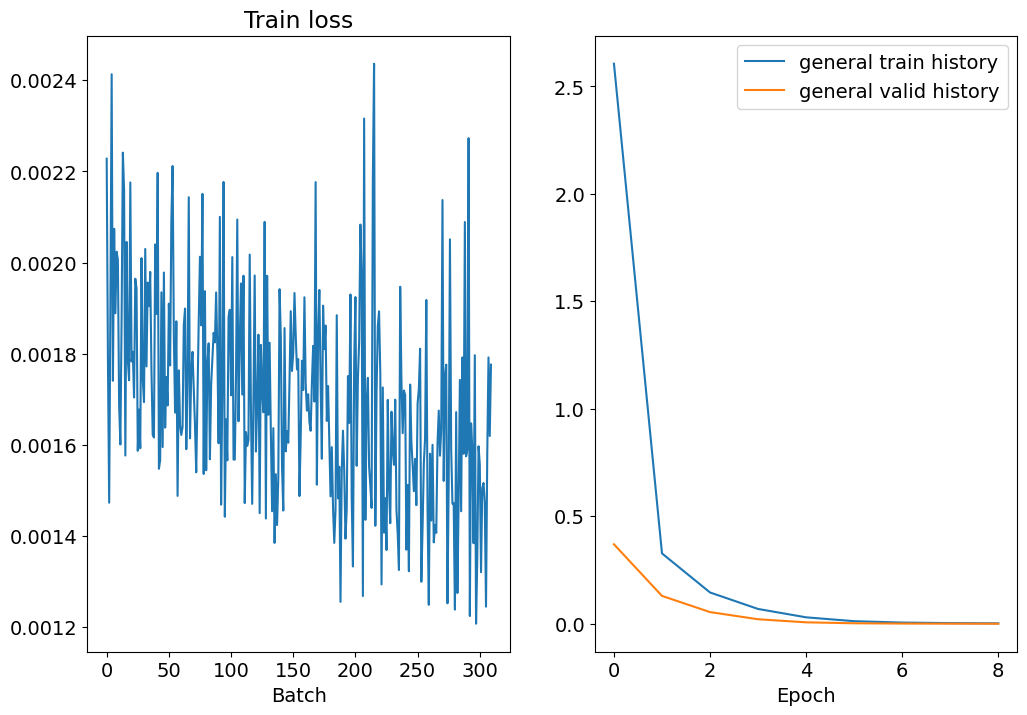

Epoch: 10 | Time: 0m 26s
	Train Loss: 0.002 | Train PPL:   1.002
	 Val. Loss: 0.000 |  Val. PPL:   1.000


In [21]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_three, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_model_two(model_three, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_three.state_dict(), 'attn-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [22]:
import tqdm

original_text = []
generated_text = []
model_three.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model_three(src, trg) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

59it [00:00, 74.91it/s]


In [23]:
from nltk.translate.bleu_score import corpus_bleu
corpus_bleu([[text] for text in original_text], generated_text) * 100

69.17004320994681